## Imports & Load Data

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import researchpy as rp
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import tikzplotlib
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('step0_results.csv', na_values=['no info', '.'], delimiter=',')

In [4]:
#df

## Prepare Table for Statistical Analysis

In [5]:
new_columns = ['date']

for i in range(1, 10):
    for j in range(1, 13):
        new_columns.append(str(i)+str(j))

new_columns.append('feedback')
df.columns = new_columns
df.drop(['date', 'feedback'], axis=1, inplace=True)

In [6]:
df.replace('Strongly disagree', 1, inplace=True)
df.replace('Disagree', 2, inplace=True)
df.replace('Neutral', 3, inplace=True)
df.replace('Agree', 4, inplace=True)
df.replace('Strongly Agree', 5, inplace=True)

df.replace('< 5 min', 1, inplace=True)
df.replace('5 - 15 min', 2, inplace=True)
df.replace('15 - 30 min', 3, inplace=True)
df.replace('30 - 60 min', 4, inplace=True)
df.replace('> 60 min', 5, inplace=True)

In [7]:
#df

In [8]:
# multiplication of values with 1 or -1 depending on the question effect
for column in df:
    r = int(column)%10
    if r == 7 or r == 8 or r == 9 or r == 0:
        #df[column] = df[column]*(-1) # for having negative effect of question
        df[column] = 6 - df[column]

In [9]:
df

,11,12,13,14,15,16,17,18,19,110,...,93,94,95,96,97,98,99,910,911,912
0,2,4,2,2,5,4,4,4,3,4,...,4,4,5,4,4,4,4,4,5,4
1,4,3,4,4,4,4,3,4,3,5,...,4,4,3,4,3,4,3,3,2,1
2,1,1,1,1,2,2,3,4,3,2,...,3,2,2,2,3,4,3,5,1,1
3,4,1,1,2,4,4,4,4,3,2,...,3,4,2,3,4,5,4,5,3,3
4,4,5,4,3,4,4,4,3,3,4,...,4,4,3,2,3,4,4,2,3,2
5,2,3,2,2,4,3,2,4,2,4,...,3,4,5,4,3,5,2,5,3,1
6,4,4,4,4,2,2,3,2,3,3,...,2,3,3,3,4,4,4,4,5,1
7,2,2,2,3,4,4,2,4,2,4,...,2,3,4,4,3,4,3,4,3,1
8,4,4,4,4,3,4,3,4,4,4,...,3,2,4,4,3,3,3,4,2,2
9,4,2,1,4,2,2,2,2,2,3,...,3,4,4,3,4,4,4,4,4,3


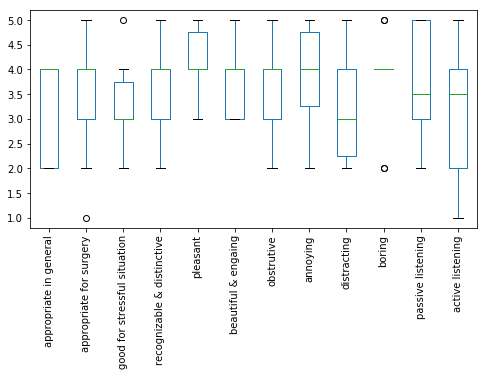

In [19]:
input_boxplot_nature_three = df.iloc[:, 24:36]
input_boxplot_nature_three.columns = ['appropriate in general', 'appropriate for surgery', 
                                      'good for stressful situation', 'recognizable & distinctive', 
                                      'pleasant', 'beautiful & engaing', 'obstrutive', 'annoying', 
                                      'distracting', 'boring', 'passive listening', 'active listening']
boxplot_nature_three = input_boxplot_nature_three.boxplot(column=['appropriate in general', 'appropriate for surgery', 
                                      'good for stressful situation', 'recognizable & distinctive', 
                                      'pleasant', 'beautiful & engaing', 'obstrutive', 'annoying', 
                                      'distracting', 'boring', 'passive listening', 'active listening'],
                                                          
                                                          rot=90,
                                                          grid=False, 
                                                          figsize=(8, 4))
#tikzplotlib.save('boxplot_nat.tex', figureheight='5cm', figurewidth='9cm')
plt.savefig("boxplot-nature.pdf")

## Sum Points Over Questions

In [53]:
sumOverAll = np.nan
sumOverAll = df.sum(axis = 0)
sumOverAll

11     31
12     29
13     25
14     29
15     34
16     33
17     30
18     35
19     28
110    35
111    25
112    15
21     30
22     20
23     21
24     29
25     30
26     28
27     27
28     29
29     24
210    35
211    20
212    15
31     32
32     35
33     33
34     37
35     41
36     38
       ..
77     35
78     42
79     33
710    40
711    31
712    24
81     35
82     29
83     35
84     34
85     40
86     37
87     36
88     41
89     33
810    39
811    30
812    27
91     32
92     25
93     31
94     34
95     35
96     33
97     34
98     41
99     34
910    40
911    31
912    19
Length: 108, dtype: int64

In [64]:
print(sumOverAll[10])
print(sumOverAll[10+12])
print(sumOverAll[10+24])
print(sumOverAll[10+36])
print(sumOverAll[10+48])
print(sumOverAll[10+60])
print(sumOverAll[10+72])
print(sumOverAll[10+84])
print(sumOverAll[10+96])

25
20
37
23
26
25
31
30
31


In [11]:
sum_over_q = np.empty([1,9], dtype=int)

for i in range(9):
    sum_over_q[0,i] = sumOverAll[i*12:(i*12)+12].sum(axis=0)
    
sum_over_q

array([[349, 308, 427, 397, 400, 383, 417, 416, 389]])

In [56]:
sum_for_pass = np.empty([1,9], dtype=int)

for i in range(1, 10):
    sum_for_pass[0, i-1] = sumOverAll.iloc[0, i*10]
    
sum_for_pass

IndexingError: Too many indexers

In [12]:
sum_over_questions_per_son = pd.DataFrame(sum_over_q, columns=['1', '2', '3', '4', '5', '6', '7', '8', '9'])
sum_over_questions_per_son

,1,2,3,4,5,6,7,8,9
0,349,308,427,397,400,383,417,416,389


In [13]:
qs = np.empty([1,len(df.columns)], dtype=int)

for i in range(len(df.columns)):
    qs[:,i] = df.iloc[:,i].sum()
#qs

## ANOVA

In [14]:
input_for_anova = np.empty([9, 10], dtype=int)

for i in range(9):
    for j in range(10):
        input_for_anova[i, j] = df.iloc[j, i*12:(i*12)+12].sum(axis=0)

ones = [1,1,1,1,1,1,1,1,1,1]
twos = [2,2,2,2,2,2,2,2,2,2]
threes = [3,3,3,3,3,3,3,3,3,3]
group = np.concatenate((np.asarray(ones), np.asarray(twos), np.asarray(threes)), axis=0)

#input_for_anova

In [15]:
b=input_for_anova.sum(axis=1)
b/600

array([0.58166667, 0.51333333, 0.71166667, 0.66166667, 0.66666667,
       0.63833333, 0.695     , 0.69333333, 0.64833333])

### ANOVA for Nature

In [16]:
input_for_anova_nature = pd.DataFrame(data=input_for_anova[0:3,])
input_for_anova_nature = np.transpose(input_for_anova_nature)
anova_nature = input_for_anova_nature[0].append(input_for_anova_nature[1]).append(input_for_anova_nature[2]).reset_index(drop=True)
nature = pd.DataFrame(data={'effect': anova_nature, 'group': group})

In [17]:
results_nature = ols('effect ~ C(group)', data=nature).fit()
results_nature.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effect   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     6.298
Date:                Sun, 27 Oct 2019   Prob (F-statistic):            0.00569
Time:                        13:31:11   Log-Likelihood:                -101.90
No. Observations:                  30   AIC:                             209.8
Df Residuals:                      27   BIC:                             214.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        34.9000      2.409     14.489      0.000      29.958      39.842
C(group)[T.2]    -4.1000      3.407     -1.204      0.239     -11.090       2.890
C(group)[T.3]     7.8000      3.407      2.290      0.030       0.810      14.790
==============================================================================
Omnibus:                        1.197   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.550   Jarque-Bera (JB):                0.916
Skew:                           0.108   Prob(JB):                        0.633
Kurtosis:                       2.172   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
rp.summary_cont(nature['effect'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,effect,30.0,36.133333,8.90073,1.625043,32.809746,39.45692


In [19]:
rp.summary_cont(nature['effect'].groupby(nature['group']))

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
1,10,34.9,7.125073,2.253146,30.244952,39.555048
2,10,30.8,8.052605,2.546457,25.538965,36.061035
3,10,42.7,7.645623,2.417758,37.704859,47.695141


In [20]:
aov_table_nature = sm.stats.anova_lm(results_nature, typ=2)
aov_table_nature

,sum_sq,df,F,PR(>F)
C(group),730.866667,2.0,6.298162,0.005689
Residual,1566.600000,27.0,NaN,NaN


In [21]:
mc_nature = MultiComparison(nature['effect'], nature['group'])
mc_results_nature = mc_nature.tukeyhsd()
print(mc_results_nature)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  1      2      -4.1   -12.5446  4.3446 False 
  1      3      7.8    -0.6446  16.2446 False 
  2      3      11.9    3.4554  20.3446  True 
----------------------------------------------


#### BONFERRONI CORRECTION POST-HOC COMPARISON

In [22]:
corrected_p_value = 0.05/3
corrected_p_value

0.016666666666666666

In [23]:
stats.ttest_ind(nature['effect'][nature['group'] == 1], nature['effect'][nature['group'] == 2])

Ttest_indResult(statistic=1.20582440429495, pvalue=0.2434971634602276)

In [24]:
stats.ttest_ind(nature['effect'][nature['group'] == 2], nature['effect'][nature['group'] == 3])

Ttest_indResult(statistic=-3.3889520422764856, pvalue=0.003270548392391994)

In [25]:
stats.ttest_ind(nature['effect'][nature['group'] == 1], nature['effect'][nature['group'] == 3])

Ttest_indResult(statistic=-2.3601472444022247, pvalue=0.029758086514941592)

### ANOVA for Algo_Music

In [26]:
input_for_anova_algomus = pd.DataFrame(data=input_for_anova[3:6,])
input_for_anova_algomus = np.transpose(input_for_anova_algomus)
anova_algomus = input_for_anova_algomus[0].append(input_for_anova_algomus[1]).append(input_for_anova_algomus[2]).reset_index(drop=True)
algomus = pd.DataFrame(data={'effect': anova_algomus, 'group': group})

In [27]:
results_algomus = ols('effect ~ C(group)', data=algomus).fit()
results_algomus.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effect   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.1275
Date:                Sun, 27 Oct 2019   Prob (F-statistic):              0.881
Time:                        13:31:11   Log-Likelihood:                -103.51
No. Observations:                  30   AIC:                             213.0
Df Residuals:                      27   BIC:                             217.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        39.7000      2.542     15.620      0.000      34.485      44.915
C(group)[T.2]     0.3000      3.594      0.083      0.934      -7.075       7.675
C(group)[T.3]    -1.4000      3.594     -0.389      0.700      -8.775       5.975
==============================================================================
Omnibus:                        0.183   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.358
Skew:                          -0.142   Prob(JB):                        0.836
Kurtosis:                       2.546   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
aov_table_algomus = sm.stats.anova_lm(results_algomus, typ=2)
aov_table_algomus

,sum_sq,df,F,PR(>F)
C(group),16.466667,2.0,0.127451,0.880863
Residual,1744.200000,27.0,NaN,NaN


In [29]:
rp.summary_cont(algomus['effect'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,effect,30.0,39.333333,7.791832,1.422587,36.423816,42.242851


In [30]:
rp.summary_cont(algomus['effect'].groupby(algomus['group']))

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
1,10,39.7,7.513691,2.376038,34.791055,44.608945
2,10,40.0,8.705043,2.752776,34.312705,45.687295
3,10,38.3,7.846443,2.481263,33.173657,43.426343


In [31]:
mc_algomus = MultiComparison(algomus['effect'], algomus['group'])
mc_results_algomus = mc_algomus.tukeyhsd()
print(mc_results_algomus)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2      0.3    -8.6105  9.2105 False 
  1      3      -1.4   -10.3105 7.5105 False 
  2      3      -1.7   -10.6105 7.2105 False 
---------------------------------------------


#### BONFERRONI CORRECTION POST-HOC COMPARISON

In [32]:
stats.ttest_ind(algomus['effect'][algomus['group'] == 1], algomus['effect'][algomus['group'] == 2])

Ttest_indResult(statistic=-0.08249939844407873, pvalue=0.9351600964690188)

In [33]:
stats.ttest_ind(algomus['effect'][algomus['group'] == 2], algomus['effect'][algomus['group'] == 3])

Ttest_indResult(statistic=0.4587154553125967, pvalue=0.6519289448504733)

In [34]:
stats.ttest_ind(algomus['effect'][algomus['group'] == 1], algomus['effect'][algomus['group'] == 3])

Ttest_indResult(statistic=0.40751738598894466, pvalue=0.6884338236896326)

### ANOVA for Japan

In [35]:
input_for_anova_japan = pd.DataFrame(data=input_for_anova[6:9,])
input_for_anova_japan = np.transpose(input_for_anova_japan)
anova_japan = input_for_anova_japan[0].append(input_for_anova_japan[1]).append(input_for_anova_japan[2]).reset_index(drop=True)
japan = pd.DataFrame(data={'effect': anova_japan, 'group': group})

In [36]:
results_japan = ols('effect ~ C(group)', data=japan).fit()
results_japan.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effect   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.4562
Date:                Sun, 27 Oct 2019   Prob (F-statistic):              0.638
Time:                        13:31:11   Log-Likelihood:                -101.18
No. Observations:                  30   AIC:                             208.4
Df Residuals:                      27   BIC:                             212.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        41.7000      2.352     17.731      0.000      36.874      46.526
C(group)[T.2]    -0.1000      3.326     -0.030      0.976      -6.924       6.724
C(group)[T.3]    -2.8000      3.326     -0.842      0.407      -9.624       4.024
==============================================================================
Omnibus:                        3.352   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                2.757
Skew:                          -0.737   Prob(JB):                        0.252
Kurtosis:                       2.822   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
aov_table_japan = sm.stats.anova_lm(results_japan, typ=2)
aov_table_japan

,sum_sq,df,F,PR(>F)
C(group),50.466667,2.0,0.456207,0.638478
Residual,1493.400000,27.0,NaN,NaN


In [38]:
rp.summary_cont(japan['effect'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,effect,30.0,40.733333,7.296354,1.332126,38.00883,43.457837


In [39]:
rp.summary_cont(japan['effect'].groupby(japan['group']))

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
1,10,41.7,7.303728,2.309642,36.928231,46.471769
2,10,41.6,8.643559,2.733333,35.952875,47.247125
3,10,38.9,6.154492,1.946221,34.879065,42.920935


In [40]:
mc_japan = MultiComparison(japan['effect'], japan['group'])
mc_results_japan = mc_japan.tukeyhsd()
print(mc_results_japan)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper reject
-------------------------------------------
  1      2      -0.1    -8.345 8.145 False 
  1      3      -2.8   -11.045 5.445 False 
  2      3      -2.7   -10.945 5.545 False 
-------------------------------------------


#### BONFERRONI CORRECTION POST-HOC COMPARISON

In [41]:
stats.ttest_ind(japan['effect'][japan['group'] == 1], japan['effect'][japan['group'] == 2])

Ttest_indResult(statistic=0.027944785969957735, pvalue=0.978013686694285)

In [42]:
stats.ttest_ind(japan['effect'][japan['group'] == 2], japan['effect'][japan['group'] == 3])

Ttest_indResult(statistic=0.804666641674566, pvalue=0.4315126079471827)

In [43]:
stats.ttest_ind(japan['effect'][japan['group'] == 1], japan['effect'][japan['group'] == 3])

Ttest_indResult(statistic=0.9270597109537073, pvalue=0.36616006058726447)